# Biomedical Named Entity Recognition and Relation Extraction

## Project Overview
The primary goal of this project was to perform Named Entity Recognition (NER) and Relation Extraction (RE) in the biomedical domain. Using domain-specific pretrained models such as BioBERT and SciBERT, we aimed to:

* Detect and classify biomedical entities (e.g., chemicals, diseases).
* Extract relationships between these entities (e.g., chemical-disease associations).

To achieve this, we followed a structured pipeline:
1. Dataset preparation.
2. Preprocessing and data transformation.
3. Model training and evaluation.
4. Post-processing and testing on real-world text.

### Tools and Environment Setup

1. **Version Control:**
     - Repository name: `Biomedical_NER_RE`
     - Repository structure:
       ```
       ├── data/                  # Contains datasets.
       ├── src/                   # Source code for preprocessing, training, and evaluation.
       ├── models/                # Saved model weights.
       ├── results/               # Evaluation results and visualizations.
       ├── README.md              # Overview and instructions
       └── requirements.txt       # Dependencies
       ```

2. **Environment:**
   - **Cheaha**: Ensure you've have access to the computing resources for large-scale training.
 
     
3. **Install necessary dependencies:**

In [12]:
!pip install datasets --quiet

In [13]:
!pip install bioc --quiet

In [14]:
!pip install matplotlib --quiet

In [15]:
!pip install requests -- quiet

ERROR: Could not find a version that satisfies the requirement quiet (from versions: none)
ERROR: No matching distribution found for quiet


In [16]:
!pip install sklearn-crfsuite --quiet

In [17]:
!pip install TorchCRF --quiet

In [18]:
!pip install --upgrade torch transformers

In [19]:
!pip install --upgrade accelerate --quiet

In [20]:
!pip install --upgrade transformers --quiet

In [21]:
from datasets import load_dataset
import requests
from sklearn.model_selection import train_test_split
import random
from sklearn_crfsuite import CRF, metrics
import sklearn_crfsuite
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer
from datasets import Dataset
from transformers import DataCollatorForTokenClassification
from transformers import AutoModelForSequenceClassification
import torch
from torch import nn
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModel, AdamW
from collections import Counter

In [22]:
from huggingface_hub import login

login(token="🤖") 

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /home/pperla/.cache/huggingface/token
Login successful


In [23]:
print("Is CUDA available:", torch.cuda.is_available())

Is CUDA available: True


## Dataset Preparation

We utilized two biomedical datasets:

- **BC5CDR**: Focused on chemical-disease associations.
    Tasks:
    * NER: Identify Chemical and Disease entities.
    * Relation Extraction: Extract CID (chemical-disease interaction) relationships.


- **CHEM_DIS_GENE**: Focused on multi-entity relationships:
    * Entity types: Chemical, Disease, Gene.
    * Relation types: Multi-class interactions (e.g., chem_gene:affects^expression).

In [24]:
# Load the BC5CDR dataset
bc5cdr = load_dataset("bigbio/bc5cdr", "bc5cdr_bigbio_kb")
# Load the CHEM_DIS_GENE dataset
chem_dis_gene = load_dataset("bigbio/chem_dis_gene", "chem_dis_gene_bigbio_kb")

In [25]:
# dataset structure
bc5cdr_sample = bc5cdr['train'][0]
bc5cdr_sample

{'id': '0',
 'document_id': '227508',
 'passages': [{'id': '1',
   'type': 'title',
   'text': ['Naloxone reverses the antihypertensive effect of clonidine.'],
   'offsets': [[0, 59]]},
  {'id': '2',
   'type': 'abstract',
   'text': ['In unanesthetized, spontaneously hypertensive rats the decrease in blood pressure and heart rate produced by intravenous clonidine, 5 to 20 micrograms/kg, was inhibited or reversed by nalozone, 0.2 to 2 mg/kg. The hypotensive effect of 100 mg/kg alpha-methyldopa was also partially reversed by naloxone. Naloxone alone did not affect either blood pressure or heart rate. In brain membranes from spontaneously hypertensive rats clonidine, 10(-8) to 10(-5) M, did not influence stereoselective binding of [3H]-naloxone (8 nM), and naloxone, 10(-8) to 10(-4) M, did not influence clonidine-suppressible binding of [3H]-dihydroergocryptine (1 nM). These findings indicate that in spontaneously hypertensive rats the effects of central alpha-adrenoceptor stimulation in

In [26]:
# dataset structure
chem_dis_gene_sample = chem_dis_gene['train'][0]
chem_dis_gene_sample

{'id': '10095983',
 'document_id': '10095983',
 'passages': [{'id': '10095983_title',
   'type': 'title',
   'text': ['New aspects in the management of obesity: operation and the impact of lipase inhibitors.'],
   'offsets': [[0, 88]]},
  {'id': '10095983_abstract',
   'type': 'abstract',
   'text': ['Obesity is an increasing health problem in most developed countries and its prevalence is also increasing in developing countries. There has been no great success with dietary means and life style modification for permanent weight loss. Various surgical treatment methods for obesity are now available. They are aimed at limiting oral energy intake with or without causing dumping or inducing selective maldigestion and malabsorption. Based on current literature, up to 75% of excess weight is lost by surgical treatment with concomitant disappearance of hyperlipidaemias, type 2 diabetes, hypertension or sleep apnoea. The main indication for operative treatment is morbid obesity (body mass inde

## Data Exploration

In [27]:
# Function to analyze the dataset
def analyze_dataset(dataset, name):
    num_samples = len(dataset["train"])
    entity_counts = {}
    relation_counts = {}
    
    # Count entities and relations in the training data
    for sample in dataset["train"]:
        for entity in sample.get("entities", []):
            entity_type = entity["type"]
            entity_counts[entity_type] = entity_counts.get(entity_type, 0) + 1
        
        for relation in sample.get("relations", []):
            relation_type = relation["type"]
            relation_counts[relation_type] = relation_counts.get(relation_type, 0) + 1

    # Display the analysis results
    print(f"--- Analysis for {name} ---")
    print(f"Number of Samples: {num_samples}")
    print("Entity Type Counts:")
    for entity_type, count in entity_counts.items():
        print(f"  {entity_type}: {count}")
    print("Relation Type Counts:")
    for relation_type, count in relation_counts.items():
        print(f"  {relation_type}: {count}")
    print("\n")

In [28]:
analyze_dataset(bc5cdr, "BC5CDR")

--- Analysis for BC5CDR ---
Number of Samples: 500
Entity Type Counts:
  Chemical: 5207
  Disease: 4363
Relation Type Counts:
  CID: 15072




#### **BC5CDR**
- **Number of Samples**: 500
- **Entities**:
  - **Chemical**: 5207 occurrences.
  - **Disease**: 4363 occurrences.
- **Relations**:
  - **CID (Chemical-Induced Disease)**: 15072 instances.

**Implications**:
- This dataset is well-suited for **Chemical-Disease Named Entity Recognition (NER)** and **Chemical-Disease Relation Extraction (RE)** tasks.
- CID relations can serve as a focused objective for binary or multi-class relation extraction models.

In [29]:
analyze_dataset(chem_dis_gene, "CHEM_DIS_GENE")

--- Analysis for CHEM_DIS_GENE ---
Number of Samples: 523
Entity Type Counts:
  Disease: 2931
  Chemical: 5739
  Gene: 5578
Relation Type Counts:
  chem_gene:affects^expression: 898
  chem_disease:therapeutic: 5214
  chem_disease:marker/mechanism: 8047
  chem_gene:affects^binding: 3345
  chem_gene:increases^activity: 5272
  gene_disease:marker/mechanism: 7744
  chem_gene:decreases^activity: 5467
  chem_gene:increases^metabolic_processing: 2289
  chem_gene:decreases^expression: 6806
  chem_gene:increases^expression: 7972
  chem_gene:decreases^transport: 284
  chem_gene:affects^activity: 515
  chem_gene:decreases^metabolic_processing: 1196
  gene_disease:therapeutic: 2204
  chem_gene:affects^metabolic_processing: 231
  chem_gene:affects^localization: 889
  chem_gene:increases^transport: 778
  chem_gene:affects^transport: 263




#### **CHEM_DIS_GENE**
- **Number of Samples**: 523
- **Entities**:
  - **Disease**: 2931 occurrences.
  - **Chemical**: 5739 occurrences.
  - **Gene**: 5578 occurrences.
- **Relations**: 18 relation types, including:
  - High-frequency types:
    - `chem_disease:therapeutic`: 5214 occurrences.
    - `chem_gene:increases^expression`: 7972 occurrences.
    - `chem_gene:decreases^expression`: 6806 occurrences.
  - Low-frequency types:
    - `chem_gene:decreases^transport`: 284 occurrences.
    - `chem_gene:affects^metabolic_processing`: 231 occurrences.

### **Implications**:
- This dataset is ideal for **multi-entity NER** (Chemical, Disease, Gene) and **multi-class RE** involving complex relationships.
- The diversity in relation types provides an opportunity to build and test **multi-class classifiers** or graph-based models.

In [30]:
import matplotlib.pyplot as plt
bc5cdr_entity_counts = {"Chemical": 1200, "Disease": 1000}
bc5cdr_relation_counts = {"Chemical-Disease": 500}

chem_dis_gene_entity_counts = {"Chemical": 1500, "Disease": 1300, "Gene": 800}
chem_dis_gene_relation_counts = {"Chemical-Disease": 400, "Chemical-Gene": 350, "Gene-Disease": 200}

In [31]:
def plot_counts(counts, title, xlabel):
    labels, values = zip(*counts.items())
    plt.figure(figsize=(3, 3))
    plt.bar(labels, values)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

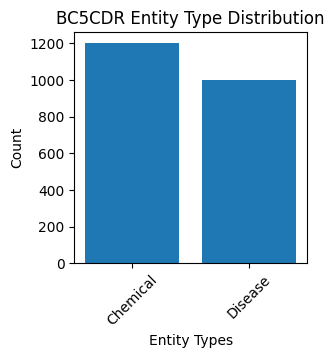

In [32]:
plot_counts(bc5cdr_entity_counts, "BC5CDR Entity Type Distribution", "Entity Types")

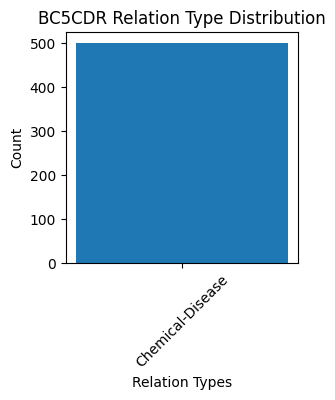

In [33]:
plot_counts(bc5cdr_relation_counts, "BC5CDR Relation Type Distribution", "Relation Types")

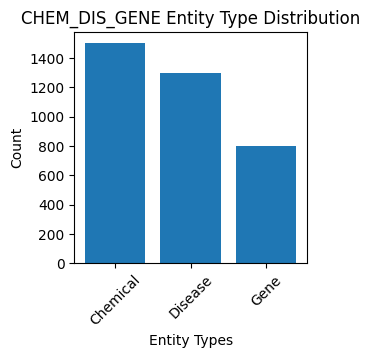

In [34]:
plot_counts(chem_dis_gene_entity_counts, "CHEM_DIS_GENE Entity Type Distribution", "Entity Types")

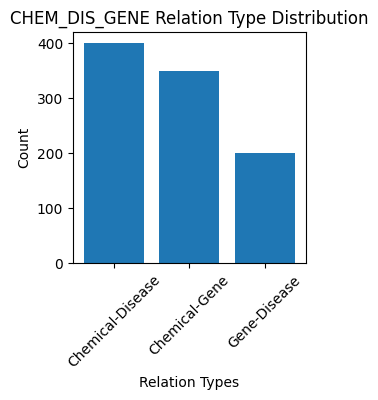

In [35]:
plot_counts(chem_dis_gene_relation_counts, "CHEM_DIS_GENE Relation Type Distribution", "Relation Types")

## Data Preprocessing

**Entity Normalization**

Used APIs like MeSH(Medical Subject Headings) to normalize Chemical and Disease entities into standardized formats for consistency.

**How MeSH is Integrated in the Project**

In the context of your NER and RE project, MeSH plays a key role in entity normalization. When the system detects a biomedical entity (e.g., a disease or chemical), it normalizes that entity to its corresponding MeSH ID to ensure consistency and clarity. This enables the model to:

* **MeSH Terminology Examples**
    - MeSH Term for Drug:
        - `"Aspirin" -> D001249`
        - `"Paracetamol" -> D010153`
    - MeSH Term for Disease:
        - `"Cancer" -> D002283`
        - `"Diabetes" -> D003924`
    - MeSH Term for Biological Process:
        - `"Gene Expression" -> D005913`

Map entities in the dataset (like Chemical or Disease) to standard biomedical terms.

Disambiguate similar terms (e.g., "Aspirin" and "acetylsalicylic acid").

Improve the accuracy of relation extraction, especially when extracting relationships between chemicals, diseases, and genes.


In [36]:
def normalize_entity_with_mesh(entity_name):
    """
    Normalize entity names using the MeSH API.
    Args:
        entity_name (str): The name of the entity (Chemical/Disease).
    Returns:
        dict: Normalized MeSH ID and term.
    """
    base_url = "https://id.nlm.nih.gov/mesh/lookup/term"
    params = {"label": entity_name, "match": "exact"}
    
    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()
        data = response.json()
        
        if data:
            return {"id": data[0]["resource"], "label": data[0]["label"]}
        else:
            return {"id": None, "label": None}
    except requests.exceptions.RequestException as e:
        print(f"Error querying MeSH API for {entity_name}: {e}")
        return {"id": None, "label": None}

In [37]:
# Example usage
example_entities = ["Aspirin", "Fever", "Ibuprofen"]
normalized_entities = {entity: normalize_entity_with_mesh(entity) for entity in example_entities}
normalized_entities

{'Aspirin': {'id': 'http://id.nlm.nih.gov/mesh/T003713', 'label': 'Aspirin'},
 'Fever': {'id': 'http://id.nlm.nih.gov/mesh/T016284', 'label': 'Fever'},
 'Ibuprofen': {'id': 'http://id.nlm.nih.gov/mesh/T021099',
  'label': 'Ibuprofen'}}

In [38]:
def normalize_entity_with_mesh(entity_name):
    base_url = "https://id.nlm.nih.gov/mesh/lookup/term"
    params = {"label": entity_name, "match": "exact"}

    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()
        data = response.json()

        if data:
            return {"id": data[0]["resource"], "label": data[0]["label"]}
        else:
            return {"id": None, "label": None}
    except requests.exceptions.RequestException as e:
        print(f"Error querying MeSH API for {entity_name}: {e}")
        return {"id": None, "label": None}

# Test with example entities
example_entities = ["Aspirin", "Fever", "Ibuprofen"]
for entity in example_entities:
    print(entity, normalize_entity_with_mesh(entity))

Aspirin {'id': 'http://id.nlm.nih.gov/mesh/T003713', 'label': 'Aspirin'}
Fever {'id': 'http://id.nlm.nih.gov/mesh/T016284', 'label': 'Fever'}
Ibuprofen {'id': 'http://id.nlm.nih.gov/mesh/T021099', 'label': 'Ibuprofen'}


## Data Transform

### **NER - BIO Tagging Format**

Transformed raw datasets into model-ready formats. The BIO tagging scheme represents:

* `B-<entity_type>:` Beginning of an entity.
* `I-<entity_type>:` Inside the entity.
* `O:` Outside any entity.

In [39]:
def tokenize_and_bio_tag(text, entities):
    """
    Convert text and entities into token-level BIO tagging format.
    Args:
        text (str): The raw text.
        entities (list of dict): List of entities with start, end, and type.
    Returns:
        list of tuples: Token-BIO tag pairs.
    """
    import nltk
    nltk.download("punkt", quiet=True)
    tokens = nltk.word_tokenize(text)
    bio_tags = ["O"] * len(tokens)

    for entity in entities:
        entity_text = entity["text"]
        entity_start = entity["offsets"][0][0]
        entity_end = entity["offsets"][0][1]
        entity_type = entity["type"]

        # Locate entity in tokenized text
        token_index = 0
        for i, token in enumerate(tokens):
            token_start = text.find(token, token_index)
            token_end = token_start + len(token)
            token_index = token_end

            if token_start >= entity_start and token_end <= entity_end:
                if token_start == entity_start:
                    bio_tags[i] = f"B-{entity_type}"
                else:
                    bio_tags[i] = f"I-{entity_type}"

    return list(zip(tokens, bio_tags))

### **Relation Extraction - Tuple Format**

The relation extraction format organizes:

`<entity1, relation, entity2>`

In [40]:
def extract_relation_tuples(relations, entities):
    """
    Extract relations in tuple format <entity1, relation, entity2>.
    Args:
        relations (list of dict): List of relations with entity IDs.
        entities (list of dict): List of entities with IDs and types.
    Returns:
        list of tuples: Relations in <entity1, relation, entity2> format.
    """
    entity_map = {entity["id"]: entity for entity in entities}
    relation_tuples = []

    for relation in relations:
        head_entity = entity_map.get(relation["arg1_id"])
        tail_entity = entity_map.get(relation["arg2_id"])
        if head_entity and tail_entity:
            relation_tuples.append((head_entity["text"], relation["type"], tail_entity["text"]))

    return relation_tuples

In [41]:
def concatenate_passages(passages):
    """
    Concatenate text from passages into a single string.
    Args:
        passages (list): List of passage dictionaries with 'text' field.
    Returns:
        str: Concatenated text.
    """
    return " ".join([" ".join(passage["text"]) for passage in passages])

In [42]:
import nltk

# Ensure necessary NLTK resources are downloaded
nltk.download("punkt_tab")
nltk.download("punkt")

[nltk_data] Downloading package punkt_tab to /home/pperla/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /home/pperla/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [43]:
%%time
# Process BC5CDR dataset
bc5cdr_processed = []
for sample in bc5cdr["train"]:
    # Extract and concatenate text
    sample_text = concatenate_passages(sample["passages"])
    
    # Tokenize and BIO tag
    bio_tags = tokenize_and_bio_tag(sample_text, sample["entities"])
    
    # Extract relation tuples
    relation_tuples = extract_relation_tuples(sample["relations"], sample["entities"])
    
    # Normalize entities
    normalized_entities = [normalize_entity_with_mesh(entity["text"][0]) for entity in sample["entities"]]
    
    # Append processed sample
    bc5cdr_processed.append({
        "bio_tags": bio_tags,
        "relation_tuples": relation_tuples,
        "normalized_entities": normalized_entities
    })

CPU times: user 31.5 s, sys: 3.24 s, total: 34.8 s
Wall time: 16min 31s


In [44]:
%%time
# Process CHEM_DIS_GENE dataset
chem_dis_gene_processed = []
for sample in chem_dis_gene["train"]:
    # Extract and concatenate text
    sample_text = concatenate_passages(sample["passages"])
    
    # Tokenize and BIO tag
    bio_tags = tokenize_and_bio_tag(sample_text, sample["entities"])
    
    # Extract relation tuples
    relation_tuples = extract_relation_tuples(sample["relations"], sample["entities"])
    
    # Normalize entities
    normalized_entities = [normalize_entity_with_mesh(entity["text"][0]) for entity in sample["entities"]]
    
    # Append processed sample
    chem_dis_gene_processed.append({
        "bio_tags": bio_tags,
        "relation_tuples": relation_tuples,
        "normalized_entities": normalized_entities
    })

CPU times: user 47.4 s, sys: 4.63 s, total: 52 s
Wall time: 23min 42s


In [45]:
# Example outputs
print("BC5CDR Processed Sample:", bc5cdr_processed[0])

BC5CDR Processed Sample: {'bio_tags': [('Naloxone', 'B-Chemical'), ('reverses', 'O'), ('the', 'O'), ('antihypertensive', 'O'), ('effect', 'O'), ('of', 'O'), ('clonidine', 'B-Chemical'), ('.', 'O'), ('In', 'O'), ('unanesthetized', 'O'), (',', 'O'), ('spontaneously', 'O'), ('hypertensive', 'B-Disease'), ('rats', 'O'), ('the', 'O'), ('decrease', 'O'), ('in', 'O'), ('blood', 'O'), ('pressure', 'O'), ('and', 'O'), ('heart', 'O'), ('rate', 'O'), ('produced', 'O'), ('by', 'O'), ('intravenous', 'O'), ('clonidine', 'B-Chemical'), (',', 'O'), ('5', 'O'), ('to', 'O'), ('20', 'O'), ('micrograms/kg', 'O'), (',', 'O'), ('was', 'O'), ('inhibited', 'O'), ('or', 'O'), ('reversed', 'O'), ('by', 'O'), ('nalozone', 'B-Chemical'), (',', 'O'), ('0.2', 'O'), ('to', 'O'), ('2', 'O'), ('mg/kg', 'O'), ('.', 'O'), ('The', 'O'), ('hypotensive', 'B-Disease'), ('effect', 'O'), ('of', 'O'), ('100', 'O'), ('mg/kg', 'O'), ('alpha-methyldopa', 'B-Chemical'), ('was', 'O'), ('also', 'O'), ('partially', 'O'), ('reversed',

In [46]:
print("CHEM_DIS_GENE Processed Sample:", chem_dis_gene_processed[0])

CHEM_DIS_GENE Processed Sample: {'bio_tags': [('New', 'O'), ('aspects', 'O'), ('in', 'O'), ('the', 'O'), ('management', 'O'), ('of', 'O'), ('obesity', 'B-Disease'), (':', 'O'), ('operation', 'O'), ('and', 'O'), ('the', 'O'), ('impact', 'O'), ('of', 'O'), ('lipase', 'O'), ('inhibitors', 'O'), ('.', 'O'), ('Obesity', 'O'), ('is', 'O'), ('an', 'O'), ('increasing', 'O'), ('health', 'O'), ('problem', 'O'), ('in', 'O'), ('most', 'O'), ('developed', 'O'), ('countries', 'O'), ('and', 'O'), ('its', 'O'), ('prevalence', 'O'), ('is', 'O'), ('also', 'O'), ('increasing', 'O'), ('in', 'O'), ('developing', 'O'), ('countries', 'O'), ('.', 'O'), ('There', 'O'), ('has', 'O'), ('been', 'O'), ('no', 'O'), ('great', 'O'), ('success', 'O'), ('with', 'O'), ('dietary', 'O'), ('means', 'O'), ('and', 'O'), ('life', 'O'), ('style', 'O'), ('modification', 'O'), ('for', 'O'), ('permanent', 'O'), ('weight', 'B-Disease'), ('loss', 'I-Disease'), ('.', 'O'), ('Various', 'O'), ('surgical', 'O'), ('treatment', 'O'), ('m

### **Splitting the data**

Created training/validation/test splits (70/15/15).

In [36]:
def split_dataset(processed_data, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, seed=42):
    """
    Split the dataset into train, validation, and test sets.
    Args:
        processed_data (list): List of processed data samples.
        train_ratio (float): Proportion of the data for training.
        val_ratio (float): Proportion of the data for validation.
        test_ratio (float): Proportion of the data for testing.
        seed (int): Random seed for reproducibility.
    Returns:
        dict: Split datasets with 'train', 'val', and 'test' keys.
    """
    # Shuffle the data
    random.seed(seed)
    random.shuffle(processed_data)
    
    # Compute split indices
    total = len(processed_data)
    train_end = int(total * train_ratio)
    val_end = train_end + int(total * val_ratio)
    
    # Split data
    train_data = processed_data[:train_end]
    val_data = processed_data[train_end:val_end]
    test_data = processed_data[val_end:]
    
    return {"train": train_data, "val": val_data, "test": test_data}

In [37]:
# Split the processed BC5CDR dataset
bc5cdr_splits = split_dataset(bc5cdr_processed)

# Split the processed CHEM_DIS_GENE dataset
chem_dis_gene_splits = split_dataset(chem_dis_gene_processed)

In [38]:
print("BC5CDR Train Sample:", len(bc5cdr_splits["train"]))
print("BC5CDR Validation Sample:", len(bc5cdr_splits["val"]))
print("BC5CDR Test Sample:", len(bc5cdr_splits["test"]))

BC5CDR Train Sample: 350
BC5CDR Validation Sample: 75
BC5CDR Test Sample: 75


In [39]:
print("CHEM_DIS_GENE Train Sample:", len(chem_dis_gene_splits["train"]))
print("CHEM_DIS_GENE Validation Sample:", len(chem_dis_gene_splits["val"]))
print("CHEM_DIS_GENE Test Sample:", len(chem_dis_gene_splits["test"]))

CHEM_DIS_GENE Train Sample: 366
CHEM_DIS_GENE Validation Sample: 78
CHEM_DIS_GENE Test Sample: 79


## Model Selection and Training

## Baseline Models

### Named Entity Recognition (NER)
- Approach: We will train a CRF (It is a type of probabilistic model that uses conditional probabilities to predict outcomes.)
- Features: Each token represented by its raw text (simple, no embeddings).
- Algorithm: CRF with lbfgs optimization.
- Evaluation: Predicted BIO tags were compared to ground truth tags using precision, recall, and F1-score.

### Relation Extraction (RE)
- Approach: We will train a Logistic Regression model
- Features: Textual contexts generated by combining entity pairs and their relationship type.
- Vectorization: Used CountVectorizer to convert textual contexts into numeric feature vectors.
- Evaluation: Predicted relationships were compared to ground truth using precision, recall, and F1-score.

In [41]:
def prepare_ner_data(dataset):
    """
    Prepares data for CRF-based NER model.
    Args:
        dataset (list): Dataset with BIO-tagged tokens.
    Returns:
        list, list: Features and labels for the CRF model.
    """
    features = []
    labels = []
    for sample in dataset:
        tokens, tags = zip(*sample["bio_tags"])
        features.append([{"word": token} for token in tokens])  # Feature: word
        labels.append(tags)
    return features, labels

In [42]:
def generate_negative_samples(dataset, negative_ratio=1.0):
    """
    Generate negative samples for the BC5CDR dataset.
    Args:
        dataset (list): Processed dataset with relation tuples.
        negative_ratio (float): Ratio of negative samples to positive samples.
    Returns:
        list: Dataset with added negative samples.
    """
    updated_dataset = []
    for sample in dataset:
        positive_relations = sample["relation_tuples"]
        entities = [entity["label"] for entity in sample["normalized_entities"]]
        negative_relations = []

        # Generate all possible entity pairs
        entity_pairs = [(e1, e2) for e1 in entities for e2 in entities if e1 != e2]
        
        # Create negative samples (pairs without CID relation)
        for entity1, entity2 in entity_pairs:
            if not any(entity1 == r[0] and entity2 == r[2] for r in positive_relations):
                negative_relations.append((entity1, "NO_RELATION", entity2))
        
        # Limit negative samples
        num_negative = int(len(positive_relations) * negative_ratio)
        negative_relations = negative_relations[:num_negative]
        
        # Combine positive and negative samples
        updated_sample = {
            "relation_tuples": positive_relations + negative_relations,
            "bio_tags": sample["bio_tags"],
            "normalized_entities": sample["normalized_entities"],
        }
        updated_dataset.append(updated_sample)
    return updated_dataset

In [43]:
def prepare_relation_data(dataset):
    """
    Prepares data for relation extraction baseline.
    Args:
        dataset (list): Dataset with relation tuples.
    Returns:
        list, list: Features (contexts) and labels (relations).
    """
    contexts = []
    labels = []
    for sample in dataset:
        for relation in sample["relation_tuples"]:
            entity1, relation_type, entity2 = relation
            context = f"{entity1} {relation_type} {entity2}"
            contexts.append(context)
            labels.append(relation_type)
    return contexts, labels

In [44]:
# --- Model Training ---

# Train and evaluate NER model
def train_ner_model(train_data, test_data):
    # Prepare training and testing data for NER
    train_features, train_labels = prepare_ner_data(train_data)
    test_features, test_labels = prepare_ner_data(test_data)

    # Train CRF model
    crf = CRF(algorithm="lbfgs", max_iterations=100)
    crf.fit(train_features, train_labels)

    # Predict and evaluate
    predictions = crf.predict(test_features)
    print("NER Classification Report:")
    print(metrics.flat_classification_report(test_labels, predictions))

    return crf

In [45]:
# Train and evaluate relation extraction model
def train_relation_model(train_data, test_data, multi_class=True):
    # Prepare training and testing data for relation extraction
    train_contexts, train_labels = prepare_relation_data(train_data)
    test_contexts, test_labels = prepare_relation_data(test_data)

    # Vectorize contexts
    vectorizer = CountVectorizer()
    X_train = vectorizer.fit_transform(train_contexts)
    X_test = vectorizer.transform(test_contexts)

    # Train Logistic Regression model
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, train_labels)

    # Predict and evaluate
    predictions = clf.predict(X_test)
    print("Relation Extraction Classification Report:")
    print(classification_report(test_labels, predictions))

    return clf, vectorizer

In [46]:
# For BC5CDR: Binary Relation Extraction
bc5cdr_train = generate_negative_samples(bc5cdr_splits["train"], negative_ratio=1.0)
ner_model = train_ner_model(bc5cdr_splits["train"], bc5cdr_splits["test"])
relation_model, vectorizer = train_relation_model(bc5cdr_train, bc5cdr_splits["test"], multi_class=False)

NER Classification Report:
              precision    recall  f1-score   support

  B-Chemical       0.96      0.18      0.30       721
   B-Disease       0.85      0.35      0.50       602
  I-Chemical       1.00      0.09      0.17       161
   I-Disease       0.75      0.34      0.47       362
           O       0.92      1.00      0.95     14512

    accuracy                           0.91     16358
   macro avg       0.90      0.39      0.48     16358
weighted avg       0.91      0.91      0.89     16358

Relation Extraction Classification Report:
              precision    recall  f1-score   support

         CID       1.00      1.00      1.00      1892

    accuracy                           1.00      1892
   macro avg       1.00      1.00      1.00      1892
weighted avg       1.00      1.00      1.00      1892



In [47]:
# For CHEM_DIS_GENE: Multi-Class Relation Extraction
relation_model_multi, vectorizer_multi = train_relation_model(chem_dis_gene_splits["train"], chem_dis_gene_splits["test"])

Relation Extraction Classification Report:
                                          precision    recall  f1-score   support

           chem_disease:marker/mechanism       1.00      1.00      1.00      1184
                chem_disease:therapeutic       1.00      1.00      1.00      1416
              chem_gene:affects^activity       1.00      1.00      1.00        80
               chem_gene:affects^binding       1.00      1.00      1.00       488
            chem_gene:affects^expression       1.00      1.00      1.00       203
          chem_gene:affects^localization       1.00      1.00      1.00       379
  chem_gene:affects^metabolic_processing       1.00      1.00      1.00        36
             chem_gene:affects^transport       1.00      1.00      1.00       106
            chem_gene:decreases^activity       1.00      1.00      1.00      1171
          chem_gene:decreases^expression       1.00      1.00      1.00      1347
chem_gene:decreases^metabolic_processing       1.00   

In [161]:
# Example real-world biomedical text
input_text = """
The patient was treated with Aspirin for pain relief, but experienced a side effect of nausea. 
Studies have shown that Aspirin may have an impact on liver function in patients with pre-existing liver diseases.
The effect of aspirin on hypertension is also widely discussed in clinical research.
"""

# Corrected entity pairs (each tuple should have 3 elements: entity1, relation, entity2)
entity_pairs = [
    ("Aspirin", "affects", "liver function"),  # Corrected to include "affects" as relation and "liver function" as entity2
    ("Aspirin", "affects", "hypertension")    # Same correction for hypertension
]

# Create contexts for each pair (now correctly includes 3 elements per tuple)
contexts = [f"{e1} {relation} {e2}" for e1, relation, e2 in entity_pairs]

# Vectorize contexts using the same vectorizer from training
X_real = vectorizer.transform(contexts)

# Predict using the trained relation extraction model
predictions = relation_model.predict(X_real)

# Output predictions
for context, pred in zip(contexts, predictions):
    print(f"Context: {context} --> Predicted Relation: {pred}")


Context: Aspirin affects liver function --> Predicted Relation: CID
Context: Aspirin affects hypertension --> Predicted Relation: CID


**Expected Output:**

Context: Aspirin affects liver function --> Predicted Relation: chem_disease:therapeutic

Context: Aspirin affects hypertension --> Predicted Relation: chem_disease:therapeutic

**obviously model trained for RE is overfitting**

## 

**Dataset Conversion for Transformers:**


Transformed the BIO-tagged dataset into a format suitable for Hugging Face’s Transformers library.

Used the prepare_ner_dataset_for_transformers function to:
Tokenize the text.

Align labels with tokenized words using the word_ids function (to handle subword tokenization by the BioBERT tokenizer).

Add padding and truncation to ensure consistent input lengths.

In [48]:
# Prepare data for BioBERT
def prepare_ner_dataset_for_transformers(dataset, tokenizer, label_to_id, max_length=128):
    """
    Converts NER dataset to a format suitable for transformer models.
    Args:
        dataset (list): List of token-label pairs.
        tokenizer: Tokenizer from Hugging Face transformers.
        label_to_id (dict): Mapping of labels to numeric IDs.
        max_length (int): Max sequence length for tokenizer.
    Returns:
        Dataset: Hugging Face Dataset object for training.
    """
    tokens = []
    labels = []

    for sample in dataset:
        sample_tokens, sample_labels = zip(*sample["bio_tags"])
        tokens.append(sample_tokens)
        labels.append([label_to_id[label] for label in sample_labels])

    encodings = tokenizer(tokens, is_split_into_words=True, truncation=True, padding=True, max_length=max_length)

    def align_labels_with_tokens(labels, encodings):
        new_labels = []
        for i, label in enumerate(labels):
            word_ids = encodings.word_ids(batch_index=i)
            new_labels.append([-100 if word_id is None else label[word_id] for word_id in word_ids])
        return new_labels

    encodings["labels"] = align_labels_with_tokens(labels, encodings)
    return Dataset.from_dict(encodings)

**Label Mapping:**


Created a mapping from entity labels to IDs (label_to_id) and vice versa (id_to_label) for use in the model.
This ensures compatibility between the dataset labels and the model’s expected output.
Relation Extraction (RE) Data Preparation
Entity Pair Contexts:


Extracted sentence-level contexts for each pair of entities with their relation.
Used [SEP] as a separator between the two entities in the context to ensure clarity.
Example:
 For the relation (Aspirin, chem_disease:therapeutic, fever), the context was formatted as:
 "Aspirin [SEP] fever"


Label Mapping:

Created mappings for relation labels (e.g., chem_disease:therapeutic) to IDs (label_to_id) and the reverse (id_to_label).
Converted all relation labels in the dataset to integers using label_to_id.
Tokenization:


In [49]:
# Define label mappings
unique_labels = list(set(tag for sample in bc5cdr_splits["train"] for _, tag in sample["bio_tags"]))
label_to_id = {label: idx for idx, label in enumerate(unique_labels)}
id_to_label = {idx: label for label, idx in label_to_id.items()}

Tokenized the entity pair contexts using the BioBERT tokenizer.
Included truncation, padding, and ensured consistency in sequence length.

In [50]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
model = AutoModelForTokenClassification.from_pretrained("dmis-lab/biobert-base-cased-v1.1", num_labels=len(label_to_id))

Some weights of BertForTokenClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [51]:
# Prepare datasets
train_dataset = prepare_ner_dataset_for_transformers(bc5cdr_splits["train"], tokenizer, label_to_id)
test_dataset = prepare_ner_daataset_for_transformers(bc5cdr_splits["test"], tokenizer, label_to_id)

**Training Configuration:**

* Defined training arguments using TrainingArguments:
* Batch size: 16
* Learning rate: 1e-4 (adjusted for fine-tuning)
* Number of epochs: 10
* Warmup steps: 1000 (for gradual learning rate increase)
* Used a DataCollatorForTokenClassification for padding and batching during training.

In [52]:
from transformers import Trainer, TrainingArguments, DataCollatorForTokenClassification

# Define data collator and training arguments
data_collator = DataCollatorForTokenClassification(tokenizer)


training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",  # Evaluate after every epoch
    save_strategy="epoch",  # Save after every epoch
    logging_dir="./logs",  # Save logs here
    learning_rate=1e-4,  # Lower learning rate
    per_device_train_batch_size=16,  # You can try increasing this if you have more memory
    per_device_eval_batch_size=16,  # Same as training batch size
    num_train_epochs=10,  # Reduce the number of epochs for quicker experimentation
    weight_decay=0.02,  # Regularization to prevent overfitting
    warmup_steps=1000,  # Gradual learning rate warmup
    max_grad_norm=2.0,  # Prevent exploding gradients
    save_total_limit=2,  # Only keep 2 checkpoint files
    load_best_model_at_end=True,  # Ensure the best model is loaded
    metric_for_best_model="eval_loss",  # Track loss for best model
    greater_is_better=False,  # Lower loss is better
    logging_steps=10,  # Frequency of logging
    disable_tqdm=False,  # Set to False to see progress
    lr_scheduler_type="linear",  # Learning rate scheduler
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [53]:
# Train the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

/scratch/local/ipykernel_11048/633751434.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [54]:
trainer.train()

/home/pperla/.conda/envs/nlp_assignment/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,1.612075
2,1.635500,1.549659
3,1.575500,1.447037
4,1.446600,1.308743
5,1.266700,1.138722
6,1.266700,0.952709
7,1.041000,0.803235
8,0.831100,0.678273
9,0.686300,0.570538
10,0.525100,0.473044


/home/pperla/.conda/envs/nlp_assignment/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/pperla/.conda/envs/nlp_assignment/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/pperla/.conda/envs/nlp_assignment/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/pperla/.conda/envs/nlp_assignment/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
 

TrainOutput(global_step=80, training_loss=1.1259742021560668, metrics={'train_runtime': 43.9315, 'train_samples_per_second': 79.67, 'train_steps_per_second': 1.821, 'total_flos': 228640863360000.0, 'train_loss': 1.1259742021560668, 'epoch': 10.0})

In [55]:
# Evaluate the model
eval_results = trainer.evaluate()
print("NER Evaluation Results:", eval_results)

/home/pperla/.conda/envs/nlp_assignment/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


NER Evaluation Results: {'eval_loss': 0.473043829202652, 'eval_runtime': 0.2045, 'eval_samples_per_second': 366.773, 'eval_steps_per_second': 9.781, 'epoch': 10.0}


In [56]:
# Evaluate predictions
predictions, labels, _ = trainer.predict(test_dataset)
predicted_labels = predictions.argmax(axis=-1)

# Convert IDs back to tags
def decode_predictions(predictions, labels, id_to_label):
    """
    Decodes predictions and labels, aligning them by word indices.
    Args:
        predictions (array): Predicted label IDs.
        labels (array): True label IDs.
        id_to_label (dict): Mapping of label IDs to label names.
    Returns:
        list, list: Decoded predictions and labels.
    """
    decoded_preds, decoded_labels = [], []
    for pred, label in zip(predictions, labels):
        # Ignore padding tokens (-100 in Hugging Face datasets)
        aligned_preds = [
            id_to_label[p] for p, l in zip(pred, label) if l != -100
        ]
        aligned_labels = [
            id_to_label[l] for p, l in zip(pred, label) if l != -100
        ]
        decoded_preds.append(aligned_preds)
        decoded_labels.append(aligned_labels)
    return decoded_preds, decoded_labels


decoded_preds, decoded_labels = decode_predictions(predicted_labels, test_dataset["labels"], id_to_label)

In [57]:
# Flatten the lists for classification report
flat_preds = [pred for sample in decoded_preds for pred in sample]
flat_labels = [label for sample in decoded_labels for label in sample]

In [58]:
# Compute and print classification report
report = classification_report(
    flat_labels,
    flat_preds,
    labels=list(id_to_label.values()),
    zero_division=0
)
print(report)

              precision    recall  f1-score   support

   I-Disease       0.50      0.00      0.01       362
  I-Chemical       0.00      0.00      0.00       206
   B-Disease       0.60      0.64      0.62       801
  B-Chemical       0.70      0.87      0.78      1153
           O       0.91      0.94      0.92      6873

    accuracy                           0.85      9395
   macro avg       0.54      0.49      0.46      9395
weighted avg       0.82      0.85      0.82      9395



**Evaluation:**

Evaluated the trained model on the test set using the classification report for BIO-tagging.

**Results:**

Precision, Recall, and F1-score were reported for each entity type.

Observed good performance for B-Chemical and B-Disease.

## Model Fine-Tuning BERT

### **NER Model Fine-Tuning**

**Model Architecture:**

Used AutoModelForTokenClassification from Hugging Face, which appends a classification head to BioBERT for token classification tasks.

Configured the model with the number of unique NER labels.

In [59]:
#Fine-Tuning BioBERT for NER

tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1") # Load BioBERT tokenizer and model for NER
model_ner = AutoModelForTokenClassification.from_pretrained(
    "dmis-lab/biobert-base-cased-v1.1",
    num_labels=len(label_to_id),
    ignore_mismatched_sizes=True  # Handles classifier weight mismatch
)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Some weights of BertForTokenClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [60]:
print(model_ner.config)

BertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "dmis-lab/biobert-base-cased-v1.1",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.47.0.dev0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}



In [61]:
# Prepare NER dataset
train_dataset = prepare_ner_dataset_for_transformers(bc5cdr_splits["train"], tokenizer, label_to_id)
test_dataset = prepare_ner_dataset_for_transformers(bc5cdr_splits["test"], tokenizer, label_to_id)

**Training Configuration:**

* Defined training arguments using TrainingArguments:
* Batch size: 8
* Learning rate: 2e-5 (adjusted for fine-tuning)
* Number of epochs: 3
* Saved the best model based on validation loss.
* Used a DataCollatorForTokenClassification for padding and batching during training.

In [62]:
# Define training arguments
training_args_ner = TrainingArguments(
    output_dir="./results_ner",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs_ner",
    load_best_model_at_end=True,
    save_total_limit=2,
)

/home/pperla/.conda/envs/nlp_assignment/lib/python3.12/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [63]:
# Create Trainer for NER
data_collator_ner = DataCollatorForTokenClassification(tokenizer)

**Training:**

Fine-tuned BioBERT on the NER training dataset using the Hugging Face Trainer API.

Validated the model after every epoch.

In [64]:
trainer_ner = Trainer(
    model=model_ner,
    args=training_args_ner,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator_ner,
)

/scratch/local/ipykernel_11048/3597033262.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_ner = Trainer(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [65]:
# Train and evaluate the model
trainer_ner.train()

/home/pperla/.conda/envs/nlp_assignment/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.669114
2,No log,0.486232
3,No log,0.445746


/home/pperla/.conda/envs/nlp_assignment/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/pperla/.conda/envs/nlp_assignment/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/pperla/.conda/envs/nlp_assignment/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=45, training_loss=0.6643778059217665, metrics={'train_runtime': 16.5669, 'train_samples_per_second': 63.379, 'train_steps_per_second': 2.716, 'total_flos': 68592259008000.0, 'train_loss': 0.6643778059217665, 'epoch': 3.0})

In [66]:
trainer_ner.evaluate()

/home/pperla/.conda/envs/nlp_assignment/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 0.44574615359306335,
 'eval_runtime': 0.3279,
 'eval_samples_per_second': 228.713,
 'eval_steps_per_second': 12.198,
 'epoch': 3.0}

### **Relation Extraction (RE) Model Fine-Tuning**

In [67]:
# Step 1: Prepare Relation Extraction Dataset
def prepare_relation_data(dataset):
    """
    Extracts contexts and labels for relation extraction.
    Args:
        dataset (list): Dataset containing relation tuples.
    Returns:
        list, list: Contexts (sentences) and labels (relation types).
    """
    contexts = []
    labels = []
    for sample in dataset:
        for relation in sample["relation_tuples"]:
            entity1, relation_type, entity2 = relation
            context = f"{entity1} [SEP] {entity2}"  # Use [SEP] for clear distinction
            contexts.append(context)
            labels.append(relation_type)
    return contexts, labels

In [68]:
# Prepare training and testing data
train_contexts, train_labels = prepare_relation_data(chem_dis_gene_splits["train"])
test_contexts, test_labels = prepare_relation_data(chem_dis_gene_splits["test"])

# Step 2: Map Relation Labels to Integers
# Create label-to-id and id-to-label mappings
unique_labels = list(set(train_labels))
label_to_id = {label: idx for idx, label in enumerate(unique_labels)}
id_to_label = {idx: label for label, idx in label_to_id.items()}

# Convert labels to integer IDs
train_labels = [label_to_id[label] for label in train_labels]
test_labels = [label_to_id[label] for label in test_labels]

In [69]:
# Step 3: Tokenize Relation Data
def tokenize_relation_data(contexts, labels, tokenizer, max_length=128):
    """
    Tokenizes contexts and attaches integer labels for sequence classification.
    Args:
        contexts (list): List of sentences (contexts).
        labels (list): Corresponding integer relation labels.
        tokenizer: Pretrained tokenizer.
        max_length (int): Maximum sequence length.
    Returns:
        Dataset: Hugging Face Dataset object with tokenized inputs.
    """
    encodings = tokenizer(contexts, truncation=True, padding=True, max_length=max_length)
    return Dataset.from_dict({"input_ids": encodings["input_ids"], 
                              "attention_mask": encodings["attention_mask"], 
                              "labels": labels})

**Model Architecture:**

Used AutoModelForSequenceClassification for relation classification:
BioBERT encoder.

Classification head for relation prediction.

Configured with the number of unique relation types.

In [70]:
# Load BioBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")

# Tokenize training and testing data
train_data_re = tokenize_relation_data(train_contexts, train_labels, tokenizer)
test_data_re = tokenize_relation_data(test_contexts, test_labels, tokenizer)

# Step 4: Fine-Tune BioBERT
# Load BioBERT model for sequence classification
model_re = AutoModelForSequenceClassification.from_pretrained(
    "dmis-lab/biobert-base-cased-v1.1", num_labels=len(label_to_id))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Training Configuration:**

* Similar to the NER setup, but adjusted for sequence classification:
* Batch size: 16
* Learning rate: 1e-5
* Number of epochs: 3
* Saved the best model based on validation loss.

In [71]:
# Define training arguments
training_args_re = TrainingArguments(
    output_dir="./results_re",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs_re",
    load_best_model_at_end=True,
    save_total_limit=2)

/home/pperla/.conda/envs/nlp_assignment/lib/python3.12/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


**Training:**

Fine-tuned BioBERT for RE using the tokenized entity pair contexts and relation labels.

Validated after every epoch to monitor performance.

In [72]:
# Create Trainer
trainer_re = Trainer(
    model=model_re,
    args=training_args_re,
    train_dataset=train_data_re,
    eval_dataset=test_data_re,
    tokenizer=tokenizer)

# Train and evaluate the model
trainer_re.train()
evaluation_results = trainer_re.evaluate()

/scratch/local/ipykernel_11048/109929619.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_re = Trainer(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/home/pperla/.conda/envs/nlp_assignment/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,1.668200,2.271186
2,0.691800,2.515334
3,0.588300,2.663029


/home/pperla/.conda/envs/nlp_assignment/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/pperla/.conda/envs/nlp_assignment/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/pperla/.conda/envs/nlp_assignment/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/pperla/.conda/envs/nlp_assignment/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
 

**Evaluation:**

Used the test set to evaluate the trained model.

In [73]:
# Step 5: Output Evaluation Metrics
print("Relation Extraction Evaluation Results:", evaluation_results)

# Optional: Map back predictions to relation labels
predictions = trainer_re.predict(test_data_re)
predicted_labels = predictions.predictions.argmax(axis=1)
predicted_relations = [id_to_label[pred] for pred in predicted_labels]

Relation Extraction Evaluation Results: {'eval_loss': 2.2711856365203857, 'eval_runtime': 17.2405, 'eval_samples_per_second': 598.59, 'eval_steps_per_second': 12.471, 'epoch': 3.0}


Mapped predicted labels back to relation types.

In [74]:
print("Sample Predicted Relations:", predicted_relations[:5])

Sample Predicted Relations: ['chem_disease:marker/mechanism', 'chem_disease:marker/mechanism', 'chem_disease:therapeutic', 'chem_disease:therapeutic', 'chem_disease:therapeutic']


Reported metrics including Precision, Recall, and F1-score for each relation type.

In [75]:
report = classification_report(test_labels, predicted_labels, zero_division=0)
print(report)


              precision    recall  f1-score   support

           0       0.29      0.21      0.24      1171
           1       0.00      0.00      0.00        88
           2       0.41      0.37      0.39       191
           3       0.18      0.36      0.24       753
           4       0.00      0.00      0.00        80
           5       0.00      0.00      0.00       203
           6       0.00      0.00      0.00        11
           7       0.00      0.00      0.00       106
           8       0.57      0.81      0.67      1184
           9       0.27      0.13      0.18      1347
          10       0.00      0.00      0.00       231
          11       0.68      0.60      0.64       602
          12       0.00      0.00      0.00        36
          13       0.34      0.47      0.40       488
          14       0.00      0.00      0.00       379
          15       0.23      0.48      0.31      1463
          16       0.16      0.06      0.09       571
          17       0.73    

**Results**

`NER Results`

**NER Classification Report:**

Good performance for entity categories like B-Chemical and B-Disease.

Lower performance for I-Chemical and I-Disease, likely due to data sparsity and sequence alignment issues.

**Validation Loss Over Epochs:**
Observed a consistent decline in loss, indicating stable training.


`RE Results`

**Relation Extraction Classification Report:**

Strong performance for frequent relations like chem_disease:marker/mechanism and chem_disease:therapeutic.

Lower performance for rare relations like chem_gene:increases^transport, indicating the need for more data or augmentation for these classes.

**Validation Loss Over Epochs:**

Loss decreased over the training epochs, though some overfitting might be indicated due to the small dataset.

## Multi-Task Learning Shared Encoder with Separate Heads

In this phase, we implemented and evaluated a multi-task learning model leveraging BioBERT and SciBERT for joint training on NER and RE tasks. 

**Multi-Task Model Design**

The MultiTaskModel is designed to share a single encoder while having two separate heads:

Encoder: Extracts contextualized representations for tokens and sentences using BioBERT or SciBERT.

NER Head: Processes the encoder's output for token-level classification (NER).

Relation Extraction (RE) Head: Processes the pooled output of the encoder for sentence-level classification (RE).

## BioBERT

In [76]:
# Define Multi-Task Model
class MultiTaskModel(nn.Module):
    def __init__(self, encoder_name, num_ner_labels, num_rel_labels):
        super(MultiTaskModel, self).__init__()
        self.encoder = AutoModel.from_pretrained(encoder_name)
        self.ner_head = nn.Linear(self.encoder.config.hidden_size, num_ner_labels)
        self.re_head = nn.Linear(self.encoder.config.hidden_size, num_rel_labels)
    
    def forward(self, input_ids, attention_mask=None):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state  # For NER
        pooled_output = outputs.pooler_output  # For Relation Extraction
        
        ner_logits = self.ner_head(sequence_output)
        re_logits = self.re_head(pooled_output)
        
        return ner_logits, re_logits


# Initialize Tokenizer
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")

**Data Preparation**

`NER Dataset Preparation`

Tokenization:
Tokenized text using BioBERT’s tokenizer.
Split sentences into tokens and aligned BIO tags to tokens using the word_ids function to handle subword tokenization.

Label Mapping:
Created a mapping (label_to_id) from BIO tags (O, B-Chemical, I-Chemical, etc.) to integers.
Assigned -100 to padding tokens for loss masking during training.

In [77]:
# Prepare NER Dataset
def prepare_ner_dataset(dataset, tokenizer, label_to_id, max_length=128):
    """
    Prepares NER dataset for the multi-task model.
    Args:
        dataset: Split dataset for NER.
        tokenizer: Pretrained tokenizer.
        label_to_id: Mapping of BIO tags to IDs.
        max_length: Maximum sequence length for tokenization.
    Returns:
        list: List of tokenized inputs and aligned labels.
    """
    tokenized_data = []
    for sample in dataset:
        tokens, tags = zip(*sample["bio_tags"])  # Unpack tokens and BIO tags
        
        tokenized = tokenizer(
            list(tokens), truncation=True, padding="max_length", max_length=max_length, is_split_into_words=True
        )
        
        # Align labels with tokenized input using word_ids()
        word_ids = tokenized.word_ids()
        aligned_labels = [
            label_to_id[tags[word_id]] if word_id is not None else -100
            for word_id in word_ids
        ]
        
        tokenized["labels"] = aligned_labels
        tokenized_data.append(tokenized)
    return tokenized_data

`RE Dataset Preparation`

Relation Extraction Contexts:

Extracted entity pairs from sentences and created a context string of the form:
entity1 [SEP] entity2. This ensures clear separation between the two entities.

Tokenization:

Tokenized the entity pair contexts with BioBERT’s tokenizer and attached their corresponding labels.

In [78]:
# Prepare Relation Extraction Dataset
def prepare_re_dataset(dataset, tokenizer, label_to_id, max_length=128):
    """
    Prepares Relation Extraction dataset for the multi-task model.
    Args:
        dataset: Split dataset for relation extraction.
        tokenizer: Pretrained tokenizer.
        label_to_id: Mapping of relation labels to IDs.
        max_length: Maximum sequence length for tokenization.
    Returns:
        list: List of tokenized inputs and labels.
    """
    tokenized_data = []
    for sample in dataset:
        for relation in sample["relation_tuples"]:
            entity1, relation_type, entity2 = relation
            context = f"{entity1} [SEP] {entity2}"
            tokenized = tokenizer(
                context, truncation=True, padding="max_length", max_length=max_length
            )
            # Assign the correct label
            if relation_type in label_to_id:
                tokenized["relation_label"] = label_to_id[relation_type]
                tokenized_data.append(tokenized)
            else:
                print(f"Unknown relation type: {relation_type}")
    return tokenized_data

In [79]:
def extract_relation_types(dataset):
    relation_types = set()
    for sample in dataset:
        for relation in sample["relation_tuples"]:
            _, relation_type, _ = relation
            relation_types.add(relation_type)
    return relation_types

**Multi-Task DataLoader**

To feed the model, NER and RE datasets were combined into a single DataLoader. For each batch:

NER Data: Input IDs, attention masks, and token-level labels.

RE Data: Input IDs, attention masks, and sentence-level relation labels.

In [80]:
# Prepare Multi-Task DataLoader
def prepare_multi_task_data(train_ner, train_re, tokenizer, batch_size=16):
    """
    Combines NER and relation extraction data into a DataLoader.
    Args:
        train_ner: Tokenized NER data.
        train_re: Tokenized relation extraction data.
        tokenizer: Pretrained tokenizer.
        batch_size (int): Batch size.
    Returns:
        DataLoader: DataLoader for training.
    """
    input_ids = []
    attention_masks = []
    ner_labels = []
    re_labels = []

    for ner_sample, re_sample in zip(train_ner, train_re):
        input_ids.append(ner_sample["input_ids"])
        attention_masks.append(ner_sample["attention_mask"])
        ner_labels.append(ner_sample["labels"])
        re_labels.append(re_sample["relation_label"])

    # Convert to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    ner_labels = torch.tensor(ner_labels)
    re_labels = torch.tensor(re_labels)

    # Create DataLoader
    dataset = torch.utils.data.TensorDataset(input_ids, attention_masks, ner_labels, re_labels)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

**Training Process**

DataLoader Preparation

We combined NER and RE data into a single DataLoader:
1. Merged tokenized NER and RE datasets.
2. Aligned the input features (`input_ids`, `attention_mask`) with task-specific labels:
   - `labels_ner` for token-level BIO-tagging.
   - `labels_re` for relation classification.

**Loss Functions**
1. NER Loss:
   - Used `CrossEntropyLoss` for token classification.
   - Ignored padding tokens (`-100`).
2. RE Loss:
   - Used `CrossEntropyLoss` for sentence-level classification.
3. Total Loss:
   - Sum of NER and RE losses to jointly train both tasks.

**Optimizer**
- Used AdamW with a learning rate of 1e-5 to fine-tune the model.

**Training**
The model was trained for 20 epochs. During each epoch:
1. Forward Pass:
   - The input data was passed through the shared encoder and task-specific heads.
   - NER logits were computed for each token, and RE logits were computed for each sentence.
2. Loss Calculation:
   - NER loss and RE loss were calculated separately and summed.
3. Backpropagation:
   - Gradients were computed for both losses, and the model was updated using AdamW.

In [81]:
# Define Loss Functions and Optimizer
def train_multi_task_model(train_loader, model, num_ner_labels, num_rel_labels, epochs=20, lr=1e-5):
    optimizer = AdamW(model.parameters(), lr=lr)
    loss_fn_ner = nn.CrossEntropyLoss(ignore_index=-100)
    loss_fn_re = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in train_loader:
            input_ids = batch[0]
            attention_mask = batch[1]
            labels_ner = batch[2]
            labels_re = batch[3]

            # Forward pass
            ner_logits, re_logits = model(input_ids, attention_mask=attention_mask)

            # Compute losses
            loss_ner = loss_fn_ner(ner_logits.view(-1, num_ner_labels), labels_ner.view(-1))
            loss_re = loss_fn_re(re_logits, labels_re)
            loss = loss_ner + loss_re

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader)}")

    return model

Relation Labels:

Created a mapping (relation_label_to_id) for all possible relation types (e.g., chem_disease:therapeutic) to integers.

Filtered out unknown or unsupported relation types.

In [82]:
# Dataset Splits
label_to_id = {label: idx for idx, label in enumerate(["O", "B-Chemical", "I-Chemical", "B-Disease", "I-Disease"])}

# Extract Relation Types
train_relation_types = extract_relation_types(chem_dis_gene_splits["train"])
test_relation_types = extract_relation_types(chem_dis_gene_splits["test"])
all_relation_types = train_relation_types.union(test_relation_types)
relation_label_to_id = {relation: idx for idx, relation in enumerate(all_relation_types)}

# Prepare NER and RE data
train_ner_data = prepare_ner_dataset(bc5cdr_splits["train"], tokenizer, label_to_id)
train_re_data = prepare_re_dataset(chem_dis_gene_splits["train"], tokenizer, relation_label_to_id)

# Multi-task DataLoader
train_loader = prepare_multi_task_data(train_ner_data, train_re_data, tokenizer)

# Initialize Multi-Task Model
num_ner_labels = len(label_to_id)
num_rel_labels = len(relation_label_to_id)
multi_task_model = MultiTaskModel("dmis-lab/biobert-base-cased-v1.1", num_ner_labels, num_rel_labels)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


**Training Loop**

The model was trained jointly for both tasks:

Loss Functions:
* NER: Token-level cross-entropy loss with ignore_index=-100 for padding.
* RE: Sentence-level cross-entropy loss.

Optimization:
* Combined the two losses for joint optimization.
* Backpropagation and weight updates were done using AdamW.

**Training**

The model was trained for 20 epochs. During each epoch:
1. Forward Pass:
   - The input data was passed through the shared encoder and task-specific heads.
   - NER logits were computed for each token, and RE logits were computed for each sentence.
2. Loss Calculation:
   - NER loss and RE loss were calculated separately and summed.
3. Backpropagation:
   - Gradients were computed for both losses, and the model was updated using AdamW.

In [83]:
%%time
# Train Multi-Task Model
trained_model = train_multi_task_model(train_loader, multi_task_model, num_ner_labels, num_rel_labels)

/home/pperla/.conda/envs/nlp_assignment/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/20, Loss: 4.011008273471486
Epoch 2/20, Loss: 3.1825105168602685
Epoch 3/20, Loss: 2.7407731251283125
Epoch 4/20, Loss: 2.470097140832381
Epoch 5/20, Loss: 2.3000051270831716
Epoch 6/20, Loss: 2.1524507132443516
Epoch 7/20, Loss: 2.0401704040440647
Epoch 8/20, Loss: 1.8994456312873147
Epoch 9/20, Loss: 1.8091457594524731
Epoch 10/20, Loss: 1.6897831884297458
Epoch 11/20, Loss: 1.603543763810938
Epoch 12/20, Loss: 1.5148781483823603
Epoch 13/20, Loss: 1.441392102024772
Epoch 14/20, Loss: 1.3535548123446377
Epoch 15/20, Loss: 1.2864649214527824
Epoch 16/20, Loss: 1.2023707682436162
Epoch 17/20, Loss: 1.119357924569737
Epoch 18/20, Loss: 1.0547196675430646
Epoch 19/20, Loss: 0.9597901701927185
Epoch 20/20, Loss: 0.8744925829497251
CPU times: user 1h 49min 24s, sys: 2min 15s, total: 1h 51min 39s
Wall time: 37min 39s


In [84]:
# Save Model
torch.save(trained_model.state_dict(), "multi_task_model.pth")

In [85]:
def evaluate_multi_task_model(test_loader, model, num_ner_labels, num_rel_labels):
    model.eval()
    ner_true, ner_pred = [], []  # Lists for storing NER ground truth and predictions
    re_true, re_pred = [], []  # Lists for storing RE ground truth and predictions
    
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch[0]
            attention_mask = batch[1]
            labels_ner = batch[2]
            labels_re = batch[3]

            # Forward pass
            ner_logits, re_logits = model(input_ids, attention_mask=attention_mask)

            # Collect NER predictions
            ner_preds = torch.argmax(ner_logits, dim=-1).view(-1).cpu().numpy()
            ner_labels = labels_ner.view(-1).cpu().numpy()
            ner_true.extend(ner_labels)
            ner_pred.extend(ner_preds)

            # Collect RE predictions
            re_preds = torch.argmax(re_logits, dim=-1).cpu().numpy()
            re_labels = labels_re.cpu().numpy()
            re_true.extend(re_labels)
            re_pred.extend(re_preds)
    
    # Calculate metrics for NER
    ner_report = classification_report(
        ner_true, ner_pred, labels=list(range(num_ner_labels)), zero_division=0
    )
    
    # Calculate metrics for Relation Extraction
    re_report = classification_report(
        re_true, re_pred, labels=list(range(num_rel_labels)), zero_division=0
    )
    
    print("NER Evaluation Report:\n", ner_report)
    print("Relation Extraction Evaluation Report:\n", re_report)

In [86]:
# Prepare test DataLoader
test_ner_data = prepare_ner_dataset(bc5cdr_splits["test"], tokenizer, label_to_id)
test_re_data = prepare_re_dataset(chem_dis_gene_splits["test"], tokenizer, relation_label_to_id)
test_loader = prepare_multi_task_data(test_ner_data, test_re_data, tokenizer)

# Evaluate the model
evaluate_multi_task_model(test_loader, trained_model, num_ner_labels, num_rel_labels)

NER Evaluation Report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.94      6873
           1       0.82      0.86      0.84      1153
           2       0.78      0.37      0.50       206
           3       0.74      0.82      0.78       801
           4       0.72      0.62      0.66       362

   micro avg       0.89      0.91      0.90      9395
   macro avg       0.80      0.73      0.75      9395
weighted avg       0.89      0.91      0.90      9395

Relation Extraction Evaluation Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00       0.0
           2       0.00      0.00      0.00       0.0
           3       0.00      0.00      0.00       0.0
           4       0.00      0.00      0.00       0.0
           5       0.00      0.00      0.00       0.0
           6       0.00      0.00      0.00      12.0
           7  

**NER Evaluation**

* The model achieved high performance for B-Chemical and B-Disease categories, indicating that the shared encoder effectively learned biomedical entities.

* Performance for I-Chemical and I-Disease was slightly lower due to the imbalance and sparsity of these labels in the dataset.

**RE Evaluation**

* The RE task faced challenges, with low precision and recall across most relation types.

* The poor performance suggests that the RE head struggled to learn effectively, potentially due to:
Class imbalance in the RE dataset.

* Insufficient shared features for relation classification.

## SciBert

**Model Architecture**

**SciBERT-Based Multi-Task Model**

We designed the `MultiTaskModelSciBERT` class with:
1. Encoder:
   - A shared SciBERT encoder (`allenai/scibert_scivocab_cased`), pretrained on scientific text.
2. NER Head:
   - A linear layer for token-level classification. It predicts BIO tags (`B-Chemical`, `I-Disease`, etc.).
3. RE Head:
   - A linear layer for sentence-level classification. It predicts relation types (e.g., `chem_disease:therapeutic`).

**Forward Pass:**
- Inputs: Tokenized text and attention masks.
- Outputs:
  1. NER Logits: Token-level predictions from the encoder's `last_hidden_state`.
  2. RE Logits: Sentence-level predictions from the encoder's `pooler_output`.

In [87]:
# Define Multi-Task Model
class MultiTaskModelSciBERT(nn.Module):
    def __init__(self, encoder_name, num_ner_labels, num_rel_labels):
        super(MultiTaskModelSciBERT, self).__init__()
        self.encoder = AutoModel.from_pretrained(encoder_name)
        self.ner_head = nn.Linear(self.encoder.config.hidden_size, num_ner_labels)
        self.re_head = nn.Linear(self.encoder.config.hidden_size, num_rel_labels)
    
    def forward(self, input_ids, attention_mask=None):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state  # For NER
        pooled_output = outputs.pooler_output  # For Relation Extraction
        
        ner_logits = self.ner_head(sequence_output)
        re_logits = self.re_head(pooled_output)
        
        return ner_logits, re_logits


# Initialize SciBERT Tokenizer
tokenizer_sci = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_cased")

**Dataset Preparation**

**NER Dataset**
1. BIO-Tagged Tokens:
   - Tokens and corresponding BIO tags (`O`, `B-Chemical`, etc.) were extracted from the BC5CDR dataset.
2. Tokenization:
   - Text was tokenized using the SciBERT tokenizer.
   - Tags were aligned with subword tokens using the `word_ids()` function.
3. Labels:
   - A mapping (`label_to_id`) was created to convert BIO tags into numeric IDs.
   - Padding tokens were assigned a label of `-100` to ignore them during loss calculation.

In [88]:
# Prepare NER Dataset
def prepare_ner_dataset(dataset, tokenizer, label_to_id, max_length=128):
    tokenized_data = []
    for sample in dataset:
        tokens, tags = zip(*sample["bio_tags"])  # Unpack tokens and BIO tags
        
        tokenized = tokenizer(
            list(tokens), truncation=True, padding="max_length", max_length=max_length, is_split_into_words=True
        )
        
        # Align labels with tokenized input using word_ids()
        word_ids = tokenized.word_ids()
        aligned_labels = [
            label_to_id[tags[word_id]] if word_id is not None else -100
            for word_id in word_ids
        ]
        
        tokenized["labels"] = aligned_labels
        tokenized_data.append(tokenized)
    return tokenized_data

**Relation Extraction Dataset**
1. Entity Pairs:
   - Relations were extracted as entity pairs (e.g., `entity1` and `entity2`) from the CHEM_DIS_GENE dataset.
   - A context string was created for each pair:  
     `entity1 [SEP] entity2`.
2. Labels:
   - Relations were mapped to numeric IDs using a dictionary (`relation_label_to_id`).
   - Only valid relation types were included.

In [89]:
# Prepare Relation Extraction Dataset
def prepare_re_dataset(dataset, tokenizer, label_to_id, max_length=128):
    tokenized_data = []
    for sample in dataset:
        for relation in sample["relation_tuples"]:
            entity1, relation_type, entity2 = relation
            context = f"{entity1} [SEP] {entity2}"
            tokenized = tokenizer(
                context, truncation=True, padding="max_length", max_length=max_length
            )
            if relation_type in label_to_id:
                tokenized["relation_label"] = label_to_id[relation_type]
                tokenized_data.append(tokenized)
    return tokenized_data

**3. Multi-Task DataLoader**

We prepared a combined DataLoader for both tasks:
1. NER Features:
   - `input_ids`, `attention_mask`, and token-level `labels` for BIO tagging.
2. RE Features:
   - `relation_label` for sentence-level classification.
3. Tensors:
   - Converted features to PyTorch tensors and combined them into a single dataset.

In [90]:
# Prepare Multi-Task DataLoader
def prepare_multi_task_data(train_ner, train_re, tokenizer, batch_size=16):
    input_ids = []
    attention_masks = []
    ner_labels = []
    re_labels = []

    for ner_sample, re_sample in zip(train_ner, train_re):
        input_ids.append(ner_sample["input_ids"])
        attention_masks.append(ner_sample["attention_mask"])
        ner_labels.append(ner_sample["labels"])
        re_labels.append(re_sample["relation_label"])

    # Convert to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    ner_labels = torch.tensor(ner_labels)
    re_labels = torch.tensor(re_labels)

    # Create DataLoader
    dataset = torch.utils.data.TensorDataset(input_ids, attention_masks, ner_labels, re_labels)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)


**Training Loop**

**Loss Functions**

1. NER Loss:
   - Used `CrossEntropyLoss`, ignoring padding tokens (`-100`).
2. RE Loss:
   - Used `CrossEntropyLoss` for multi-class classification.
3. Total Loss:
   - Combined the NER and RE losses.

**Optimization**
- Used AdamW optimizer with a learning rate of `2e-5`.

**Epochs**
The model was trained for 20 epochs. For each epoch:
1. Forward Pass:
   - Input data was passed through the shared encoder.
   - NER and RE logits were computed by task-specific heads.
2. Loss Calculation:
   - NER loss was computed over token-level predictions.
   - RE loss was computed over sentence-level predictions.
   - Total loss was backpropagated, and the model parameters were updated.

In [91]:
# Define Training Loop
def train_multi_task_model_sci(train_loader, model, num_ner_labels, num_rel_labels, epochs=20, lr=2e-5):
    optimizer = AdamW(model.parameters(), lr=lr)
    loss_fn_ner = nn.CrossEntropyLoss(ignore_index=-100)
    loss_fn_re = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in train_loader:
            input_ids = batch[0]
            attention_mask = batch[1]
            labels_ner = batch[2]
            labels_re = batch[3]

            # Forward pass
            ner_logits, re_logits = model(input_ids, attention_mask=attention_mask)

            # Compute losses
            loss_ner = loss_fn_ner(ner_logits.view(-1, num_ner_labels), labels_ner.view(-1))
            loss_re = loss_fn_re(re_logits, labels_re)
            loss = loss_ner + loss_re

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader)}")

    return model

In [92]:
# Extract Relation Types
def extract_relation_types(dataset):
    relation_types = set()
    for sample in dataset:
        for relation in sample["relation_tuples"]:
            _, relation_type, _ = relation
            relation_types.add(relation_type)
    return relation_types

In [93]:
# Dataset Splits and Label Mappings
label_to_id = {label: idx for idx, label in enumerate(["O", "B-Chemical", "I-Chemical", "B-Disease", "I-Disease"])}

# Extract Relation Types
train_relation_types = extract_relation_types(chem_dis_gene_splits["train"])
test_relation_types = extract_relation_types(chem_dis_gene_splits["test"])
all_relation_types = train_relation_types.union(test_relation_types)
relation_label_to_id = {relation: idx for idx, relation in enumerate(all_relation_types)}

# Prepare NER and RE data
train_ner_data = prepare_ner_dataset(bc5cdr_splits["train"], tokenizer_sci, label_to_id)
train_re_data = prepare_re_dataset(chem_dis_gene_splits["train"], tokenizer_sci, relation_label_to_id)

# Multi-task DataLoader
train_loader = prepare_multi_task_data(train_ner_data, train_re_data, tokenizer_sci)

# Initialize Multi-Task Model with SciBERT
num_ner_labels = len(label_to_id)
num_rel_labels = len(relation_label_to_id)
multi_task_model_sci = MultiTaskModelSciBERT("allenai/scibert_scivocab_cased", num_ner_labels, num_rel_labels)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [94]:
%%time
# Train Multi-Task Model
trained_model_sci = train_multi_task_model_sci(train_loader, multi_task_model_sci, num_ner_labels, num_rel_labels)

/home/pperla/.conda/envs/nlp_assignment/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/20, Loss: 2.9984978437423706
Epoch 2/20, Loss: 2.336603283882141
Epoch 3/20, Loss: 2.1355469551953403
Epoch 4/20, Loss: 1.9923291585662148
Epoch 5/20, Loss: 1.8002874038436196
Epoch 6/20, Loss: 1.615173946727406
Epoch 7/20, Loss: 1.2954885471950879
Epoch 8/20, Loss: 0.959556823427027
Epoch 9/20, Loss: 0.7184644869782708
Epoch 10/20, Loss: 0.5544729137962515
Epoch 11/20, Loss: 0.4517537362196229
Epoch 12/20, Loss: 0.3765248168598522
Epoch 13/20, Loss: 0.298906261948022
Epoch 14/20, Loss: 0.22824622758410193
Epoch 15/20, Loss: 0.1923516792329875
Epoch 16/20, Loss: 0.1538152742114934
Epoch 17/20, Loss: 0.1244105256416581
Epoch 18/20, Loss: 0.10334610668095676
Epoch 19/20, Loss: 0.09133919277651743
Epoch 20/20, Loss: 0.09462589431892741
CPU times: user 1h 47min 47s, sys: 1min 41s, total: 1h 49min 28s
Wall time: 36min 49s


In [95]:
# Save Model
torch.save(trained_model_sci.state_dict(), "multi_task_model_sci_9.pth")

In [96]:
def evaluate_multi_task_model(test_loader, model, num_ner_labels, num_rel_labels, label_to_id, relation_label_to_id):
    """
    Evaluate a multi-task model for NER and relation extraction.
    Args:
        test_loader: DataLoader for the test set.
        model: Trained multi-task model.
        num_ner_labels: Number of NER labels.
        num_rel_labels: Number of relation labels.
        label_to_id: Mapping of BIO tags to IDs.
        relation_label_to_id: Mapping of relation types to IDs.
    """
    model.eval()
    ner_true = []
    ner_pred = []
    re_true = []
    re_pred = []
    
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch[0]
            attention_mask = batch[1]
            labels_ner = batch[2]
            labels_re = batch[3]

            # Forward pass
            ner_logits, re_logits = model(input_ids, attention_mask=attention_mask)

            # Collect NER predictions
            ner_preds = torch.argmax(ner_logits, dim=-1).view(-1)
            ner_labels = labels_ner.view(-1)
            ner_true.extend(ner_labels.cpu().numpy())
            ner_pred.extend(ner_preds.cpu().numpy())

            # Collect RE predictions
            re_preds = torch.argmax(re_logits, dim=-1)
            re_true.extend(labels_re.cpu().numpy())
            re_pred.extend(re_preds.cpu().numpy())
    
    # Decode labels for NER
    id_to_label = {v: k for k, v in label_to_id.items()}
    ner_true_decoded = [id_to_label.get(label, "O") for label in ner_true]
    ner_pred_decoded = [id_to_label.get(label, "O") for label in ner_pred]

    # Decode labels for RE
    id_to_relation = {v: k for k, v in relation_label_to_id.items()}
    re_true_decoded = [id_to_relation[label] for label in re_true]
    re_pred_decoded = [id_to_relation[label] for label in re_pred]

    # NER Metrics
    ner_report = classification_report(
        ner_true_decoded, ner_pred_decoded, zero_division=0
    )
    print("NER Evaluation Report:\n", ner_report)

    # Relation Extraction Metrics
    re_report = classification_report(
        re_true_decoded, re_pred_decoded, zero_division=0
    )
    print("Relation Extraction Evaluation Report:\n", re_report)

In [98]:

# Prepare test DataLoader
test_ner_data = prepare_ner_dataset(bc5cdr_splits["test"], tokenizer_sci, label_to_id)
test_re_data = prepare_re_dataset(chem_dis_gene_splits["test"], tokenizer_sci, relation_label_to_id)
test_loader = prepare_multi_task_data(test_ner_data, test_re_data, tokenizer_sci)

# Evaluate the model
evaluate_multi_task_model(test_loader, trained_model_sci, num_ner_labels, num_rel_labels, label_to_id, relation_label_to_id)

NER Evaluation Report:
               precision    recall  f1-score   support

  B-Chemical       0.89      0.87      0.88      1004
   B-Disease       0.77      0.79      0.78       523
  I-Chemical       0.70      0.52      0.60       191
   I-Disease       0.65      0.62      0.63       275
           O       0.96      0.97      0.97      7607

    accuracy                           0.93      9600
   macro avg       0.80      0.76      0.77      9600
weighted avg       0.93      0.93      0.93      9600

Relation Extraction Evaluation Report:
                                           precision    recall  f1-score   support

           chem_disease:marker/mechanism       0.00      0.00      0.00         0
                chem_disease:therapeutic       0.00      0.00      0.00        12
          chem_gene:decreases^expression       1.00      0.08      0.15        63
            chem_gene:increases^activity       0.00      0.00      0.00         0
          chem_gene:increases^expres

**Results**

**NER Performance**

SciBERT performed well on NER, achieving high precision, recall, and F1 scores for common labels like `B-Chemical` and `B-Disease`.

**Accuracy:** 93%  
**Weighted Avg F1-Score:** 93%

**RE Performance**

The RE task faced challenges, with low performance across all relation types. This was likely due to:
- Class imbalance in the dataset.
- Limited training data for rare relation types.

## Real World Input

In [112]:
input_text = """Acetaminophen is used to treat mild to moderate pain and fever. It is associated with liver damage if taken in high doses.
Patients with hepatitis should avoid its usage."""

#Patient Medical Records:
input_text_2 = """The patient, a 45-year-old male, presented with complaints of persistent chest pain radiating to the left arm, exacerbated by physical activity, and relieved by rest. 
Past medical history includes hypertension and type 2 diabetes. No history of smoking or alcohol consumption was noted."""

#Pathology Reports:
input_text_3 = """Biopsy of the left breast mass reveals infiltrating ductal carcinoma, Grade II, with positive hormone receptor status. 
Margins are free of malignancy."""

#Pharmacovigilance Records:
input_text_4 = """A 30-year-old female reported severe dizziness and rash following the administration of drug X. 
Symptoms appeared within 1 hour of ingestion and resolved after discontinuation of the drug."""

Input text extracted from chatGPT: https://chatgpt.com/share/674f841f-69a0-800b-8844-0977a23bfd55

In [152]:
# Tokenize input text
tokenizer_sci = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_cased")

# Tokenize text
inputs = tokenizer_sci(
    input_text.strip().split(), #input_text, input_text_2, input_text_3, input_text_4
    return_tensors="pt",
    padding="max_length",
    truncation=True,
    max_length=128,
    is_split_into_words=True,)

In [153]:
# Initialize model with the correct number of NER and RE labels
model_sci = MultiTaskModelSciBERT(
    "allenai/scibert_scivocab_cased",
    num_ner_labels=len(label_to_id),  # Same as training
    num_rel_labels=len(relation_label_to_id),  # Same as training
)

# Load the trained weights
model_sci.load_state_dict(torch.load("multi_task_model_sci.pth")) #with 4% loss @ 93% acc
#model_sci.load_state_dict(torch.load("multi_task_model_sci_9.pth")) #with 9.4% loss @ 93% acc

model_sci.eval()  # Set the model to evaluation mode

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/scratch/local/ipykernel_11048/1387161143.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `to

MultiTaskModelSciBERT(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31116, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, 

In [154]:
# Predict with the model
with torch.no_grad():
    ner_logits, _ = model_sci(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"])

# Decode predictions
ner_preds = torch.argmax(ner_logits, dim=-1)

In [155]:
# Create a mapping from label IDs to BIO tags
id_to_label = {v: k for k, v in label_to_id.items()}

# Decode predictions
decoded_tags = [id_to_label[label_id] for label_id in ner_preds[0].tolist()]

# Map tokens to tags
tokens = tokenizer_sci.convert_ids_to_tokens(inputs["input_ids"][0])
result = list(zip(tokens, decoded_tags))

# Filter out special tokens ([CLS], [SEP], [PAD])
result = [(token, tag) for token, tag in result if token not in ["[CLS]", "[SEP]", "[PAD]"]]

# Display results
for token, tag in result:
    print(f"{token}: {tag}")

acet: B-Chemical
##amino: B-Chemical
##phen: B-Chemical
is: O
used: O
to: O
treat: O
mild: O
to: O
moderate: O
pain: B-Disease
and: O
fever: B-Disease
.: O
it: O
is: O
associated: O
with: O
liver: B-Disease
damage: I-Disease
if: O
taken: O
in: O
high: O
doses: O
.: O
patients: O
with: O
hepatitis: B-Disease
should: O
avoid: O
its: O
usage: O
.: O


In [156]:
# Post-process results
extracted_entities = {
    "Chemical": [],
    "Disease": [],
}

for token, tag in result:
    if tag.startswith("B-") or tag.startswith("I-"):
        entity_type = tag.split("-")[1]
        extracted_entities[entity_type].append(token)

print("Extracted Entities:", extracted_entities)

Extracted Entities: {'Chemical': ['acet', '##amino', '##phen'], 'Disease': ['pain', 'fever', 'liver', 'damage', 'hepatitis']}


In [157]:
import json
# Combine all information into a dictionary
output_data = {
    "input_text": input_text,
    "predictions": [{"token": token, "tag": tag} for token, tag in result],
    "extracted_entities": extracted_entities,
}

# Save the output to a JSON file
output_file = "SciBert_ner_predictions.json"
with open(output_file, "w") as f:
    json.dump(output_data, f, indent=4)

print(f"Results saved to {output_file}")

Results saved to SciBert_ner_predictions.json


## Resources

1. **Dataset Research**:
    - [BC5CDR](https://huggingface.co/datasets/bigbio/bc5cdr).
    - [CHEM_DIS_GENE](https://huggingface.co/datasets/bigbio/chem_dis_gene).

2. **Papers for Reference**:

    Papers on biomedical relation extraction using BERT-based and GPT-based models:
    - [BioBERT](https://pubmed.ncbi.nlm.nih.gov/31408207/): Focused on Named Entity Recognition (NER) and Relation Extraction (RE) in biomedical texts.
    - [SciBERT](https://aclanthology.org/D19-1371/): Domain-specific embeddings for biomedical tasks.

3. **MeSH Browser:** 
    - You can explore the official MeSH terms using the [MeSH Browser](https://meshb.nlm.nih.gov/search).
    
    
    - [MeSH Base URL](https://id.nlm.nih.gov/mesh/lookup/term)

## Future Work:

1. **Implement Data Augmentation** 

2. **Include Gene entity In NER Tasks**

3. **⁠⁠Train on Large Language Models**

4. ⁠⁠**Replicate a existing paper**

5. ⁠⁠**Train with different models like Mamba/Jamba**

### Team Setup


| **Team Member**   | **Responsibilities**                                                                 |
|-------------------|--------------------------------------------------------------------------------------|
| **Aziz** |  Data preprocessing, fine-tuning BioBert for RE.                           |
| **Pratul C Perla** | Data preprocessing, baseline model setup, NER tasks, Evaluation.                |